In [5]:
import csv
import pandas as pd
with open('Snappfood - Sentiment Analysis.csv', 'r', encoding='utf-8') as f:
    dialect = csv.Sniffer().sniff(f.read(1024))
    f.seek(0)
    df = pd.read_csv(f, dialect=dialect)
print(df.head())

  Unnamed: 0                                            comment  label  \
0        NaN    واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح    SAD   
1        NaN  قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از مو...  HAPPY   
2        NaN  قیمت این مدل اصلا با کیفیتش سازگاری نداره، فقط...    SAD   
3        NaN  عالللی بود همه چه درست و به اندازه و کیفیت خوب...  HAPPY   
4        NaN                      شیرینی وانیلی فقط یک مدل بود.  HAPPY   

   label_id  
0       1.0  
1       0.0  
2       1.0  
3       0.0  
4       0.0  


In [1]:
import pandas as pd

df = pd.read_csv('snappfood_processed.csv')

df = df.dropna(subset=['label_id', 'processed'])

texts = df['processed'].tolist()
labels = df['label_id'].astype(int).tolist()

In [8]:
from transformers import AutoTokenizer, TFAutoModel
import tensorflow as tf
import numpy as np
from tqdm import tqdm

tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")
bert_model = TFAutoModel.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")

def get_bert_embeddings(texts, tokenizer, model, max_len=64):
    embeddings = []
    for text in tqdm(texts):
        inputs = tokenizer(text, return_tensors='tf', max_length=max_len, truncation=True, padding='max_length')
        outputs = model(inputs)[0]
        cls_vector = outputs[:, 0, :]
        embeddings.append(cls_vector.numpy()[0])
    return np.array(embeddings)

X = get_bert_embeddings(texts, tokenizer, bert_model)
y = np.array(labels)

Some layers from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
100%|██████████| 69480/69480 [4:25:08<00:00,  4.37it/s]  


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Reshape

model = Sequential([
    Reshape((1, 768), input_shape=(768,)),
    LSTM(128, return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

C:\Users\USER\anaconda3\envs\tf-env\Lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 1, 768)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       459,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 467,585 (1.78 MB)

 Trainable params: 467,585 (1.78 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
history = model.fit(X, y, epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5
1737/1737 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8015 - loss: 0.4316 - val_accuracy: 0.8248 - val_loss: 0.3861
Epoch 2/5
1737/1737 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8310 - loss: 0.3830 - val_accuracy: 0.8262 - val_loss: 0.3789
Epoch 3/5
1737/1737 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8321 - loss: 0.3761 - val_accuracy: 0.8323 - val_loss: 0.3719
Epoch 4/5
1737/1737 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8388 - loss: 0.3662 - val_accuracy: 0.8333 - val_loss: 0.3683
Epoch 5/5
1737/1737 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8401 - loss: 0.3605 - val_accuracy: 0.8318 - val_loss: 0.3715


In [11]:
model.save('parsbert_lstm_model.h5')

In [13]:
model.save('parsbert_lstm_model.keras')

In [1]:
import pandas as pd
from transformers import AutoTokenizer, TFAutoModel
import tensorflow as tf
import numpy as np
from tqdm import tqdm

df = pd.read_excel('digikala_processed.xlsx')
texts = df['processed'].tolist()

tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")
bert_model = TFAutoModel.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")

C:\Users\USER\anaconda3\envs\tf-env\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
C:\Users\USER\anaconda3\envs\tf-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some layers from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [2]:
texts = [str(t) for t in texts if isinstance(t, str)]

def get_bert_embeddings(texts, tokenizer, model, max_len=64):
    embeddings = []
    for text in tqdm(texts):
        if not isinstance(text, str):
            continue
        inputs = tokenizer(text, return_tensors='tf', max_length=max_len,
                           truncation=True, padding='max_length')
        outputs = model(inputs)[0]
        cls_vector = outputs[:, 0, :]
        embeddings.append(cls_vector.numpy()[0])
    return np.array(embeddings)

X = get_bert_embeddings(texts, tokenizer, bert_model)

100%|██████████| 99902/99902 [6:02:12<00:00,  4.60it/s]  


In [10]:
from keras.models import load_model
model = load_model('parsbert_lstm_model.keras')

y_pred_prob = model.predict(X)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

C:\Users\USER\anaconda3\envs\tf-env\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 9 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


3122/3122 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


In [13]:
texts_raw = df['processed'].tolist()
valid_indices = [i for i, t in enumerate(texts_raw) if isinstance(t, str)]
texts = [texts_raw[i] for i in valid_indices]

df_valid = df.iloc[valid_indices].copy()
df_valid['predicted_label'] = y_pred
df_valid['predicted_sentiment'] = df_valid['predicted_label'].map({0: 'HAPPY', 1: 'SAD'})
df_valid.to_excel('digikala_predicted.xlsx', index=False)

In [11]:
df['predicted_label'] = y_pred
df['predicted_sentiment'] = df['predicted_label'].map({0: 'HAPPY', 1: 'SAD'})

df.to_excel('digikala_predicted.xlsx', index=False)

ValueError: Length of values (99902) does not match length of index (99903)

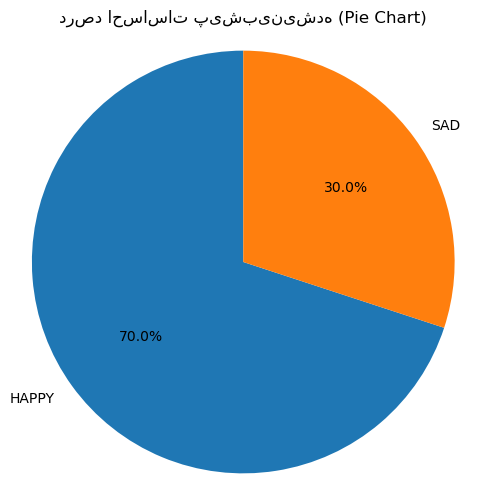

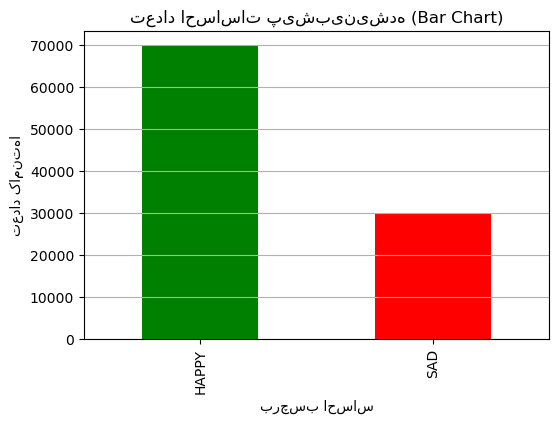

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_excel('digikala_predicted.xlsx')

label_counts = df['predicted_sentiment'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('درصد احساسات پیش‌بینی‌شده (Pie Chart)')
plt.axis('equal')
plt.show()

plt.figure(figsize=(6, 4))
label_counts.plot(kind='bar', color=['green', 'red'])
plt.title('تعداد احساسات پیش‌بینی‌شده (Bar Chart)')
plt.xlabel('برچسب احساس')
plt.ylabel('تعداد کامنت‌ها')
plt.grid(axis='y')
plt.show()